In [1]:
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import ADASYN 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTEENN 
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [2]:
wine = pd.read_csv("~/ucare-summer2020/datasets/winequality-white.csv", sep=";")

In [3]:
X = wine.drop(columns=['quality'])
y = wine['quality']
y = y > 5
y = y.astype(int)

In [4]:
scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [5]:
def report_clf(clf, X_train, X_test, y_train, y_test):
    y_train_predicted = clf.predict(X_train)
    y_train_predicted[y_train_predicted==-1] = 0
    y_test_predicted = clf.predict(X_test)
    y_test_predicted[y_test_predicted==-1] = 0
    
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))
    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))

In [6]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X.iloc[:,0].min() - 0.01, X.iloc[:, 0].max() + 0.01
    
    # Get the min and max value of feature x2
    x2min, x2max = X.iloc[:,1].min() - 0.01, X.iloc[:, 1].max() + 0.01
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()

In [109]:
def plot_boundary_clf(clf, X):
    plt.figure(figsize=(12, 6))

    decision_boundary_class_colored(clf, X)

    plt.plot(X[y==0].iloc[:,0], X[y==0].iloc[:,1], "bo", ms=3)
    plt.plot(X[y==1].iloc[:,0], X[y==1].iloc[:,1], "go", ms=3)
    
    bp = 99.9 #boundary percentile for axis scaling
    xmin0, xmax0 = np.percentile(X.iloc[:,0], 100-bp), np.percentile(X.iloc[:,0], bp)
    xmin1, xmax1 = np.percentile(X.iloc[:,1], 100-bp), np.percentile(X.iloc[:,1], bp)
    plt.axis([xmin0, xmax0, xmin1, xmax1])
    plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
    plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.title("SVM Decision Boundary Plot", fontsize=16)
    plt.show()

In [106]:
def outlier_report(feature1, feature2, gamma):
    feature_pair = [feature1, feature2]
    print("Feature 1: " + feature1 + "\nFeature 2: " + feature2)
    eff_X = X.loc[:, feature_pair]
    eff_X_test = X_test.loc[:, feature_pair]
    eff_X_train = X_train.loc[:, feature_pair]
    
    train_normal = eff_X_train[y_train==1] 
    train_outliers = eff_X_train[y_train==0]
    
    outlier_prop = len(train_outliers) / len(train_normal)
    svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
    svm.fit(train_normal)
        
    plot_boundary_clf(svm, eff_X)
    
    report_clf(svm, eff_X_train, eff_X_test, y_train, y_test)

Feature 1: volatile acidity
Feature 2: citric acid


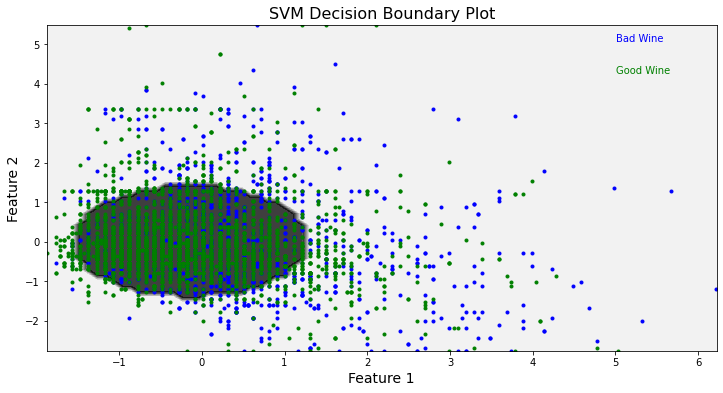


Train Accuracy:  0.6541602858601328
-----------------------------------------

Test Accuracy:  0.6520408163265307

Test Confusion Matrix:
[[112 209]
 [132 527]]

Test Precision = 0.716033
Test Recall = 0.799697
Test F1 Score = 0.755556

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.35      0.40       321
           1       0.72      0.80      0.76       659

    accuracy                           0.65       980
   macro avg       0.59      0.57      0.58       980
weighted avg       0.63      0.65      0.64       980



In [118]:
outlier_report("volatile acidity", "citric acid", 0.0000001)

Feature 1: volatile acidity
Feature 2: chlorides


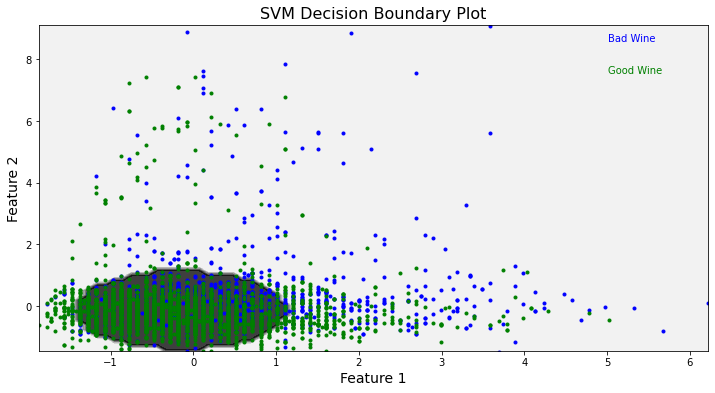


Train Accuracy:  0.6360387953037264
-----------------------------------------

Test Accuracy:  0.6551020408163265

Test Confusion Matrix:
[[ 85 236]
 [102 557]]

Test Precision = 0.702396
Test Recall = 0.845220
Test F1 Score = 0.767218

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.26      0.33       321
           1       0.70      0.85      0.77       659

    accuracy                           0.66       980
   macro avg       0.58      0.56      0.55       980
weighted avg       0.62      0.66      0.63       980



In [115]:
outlier_report("volatile acidity", "chlorides", 0.00000001)

Feature 1: volatile acidity
Feature 2: total sulfur dioxide


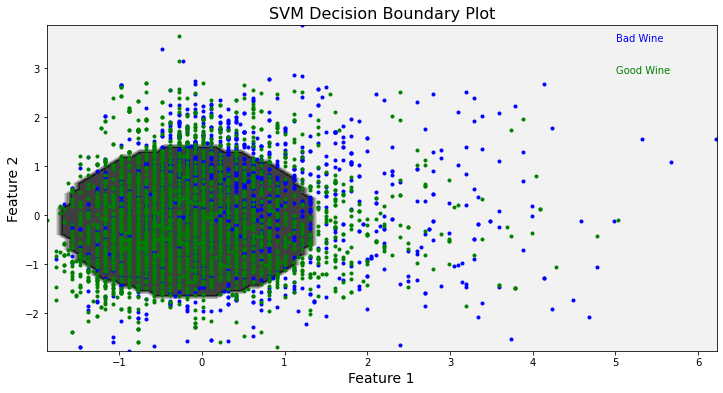


Train Accuracy:  0.6342521694742216
-----------------------------------------

Test Accuracy:  0.6408163265306123

Test Confusion Matrix:
[[ 96 225]
 [127 532]]

Test Precision = 0.702774
Test Recall = 0.807284
Test F1 Score = 0.751412

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.30      0.35       321
           1       0.70      0.81      0.75       659

    accuracy                           0.64       980
   macro avg       0.57      0.55      0.55       980
weighted avg       0.61      0.64      0.62       980



In [114]:
outlier_report("volatile acidity", "total sulfur dioxide", 0.00000001)

Feature 1: citric acid
Feature 2: total sulfur dioxide


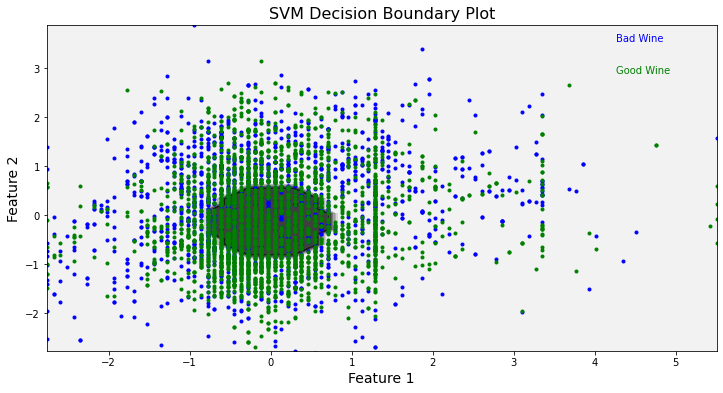


Train Accuracy:  0.5017866258295048
-----------------------------------------

Test Accuracy:  0.5010204081632653

Test Confusion Matrix:
[[260  61]
 [428 231]]

Test Precision = 0.791096
Test Recall = 0.350531
Test F1 Score = 0.485804

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.81      0.52       321
           1       0.79      0.35      0.49       659

    accuracy                           0.50       980
   macro avg       0.58      0.58      0.50       980
weighted avg       0.66      0.50      0.50       980



In [113]:
outlier_report("citric acid", "total sulfur dioxide", 0.00000001)

In [147]:
def all_feature_outlier_report(gammas):
    train_normal = X_train[y_train==1] 
    train_outliers = X_train[y_train==0]
    
    outlier_prop = len(train_outliers) / len(train_normal)
    best_acc = -1
    best_gamma = -1
    for i in gammas:
        svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=i)
        svm.fit(train_normal)
        y_test_predicted = svm.predict(X_test)
        y_test_predicted[y_test_predicted==-1] = 0
        acc = np.mean(y_test_predicted == y_test)
        if acc > best_acc:
            best_acc = acc
            best_gamma = i
    
    print("Highest accuracy gamma level: %f" % best_gamma)
    svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=best_gamma)
    svm.fit(train_normal)
    report_clf(svm, X_train, X_test, y_train, y_test)

In [150]:
gammas = [100000, 10000, 1000, 100, 10, 1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
all_feature_outlier_report(gammas)

Highest accuracy gamma level: 0.100000

Train Accuracy:  0.5535987748851455
-----------------------------------------

Test Accuracy:  0.5357142857142857

Test Confusion Matrix:
[[206 115]
 [340 319]]

Test Precision = 0.735023
Test Recall = 0.484067
Test F1 Score = 0.583715

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.64      0.48       321
           1       0.74      0.48      0.58       659

    accuracy                           0.54       980
   macro avg       0.56      0.56      0.53       980
weighted avg       0.62      0.54      0.55       980



In [155]:
def some_feature_outlier_report(gammas):
    features = ["volatile acidity", "citric acid", "chlorides", "total sulfur dioxide", "free sulfur dioxide", "pH"]
    eff_X = X.loc[:, features]
    eff_X_test = X_test.loc[:, features]
    eff_X_train = X_train.loc[:, features]
    
    train_normal = eff_X_train[y_train==1] 
    train_outliers = eff_X_train[y_train==0]
    
    outlier_prop = len(train_outliers) / len(train_normal)
    best_acc = -1
    best_gamma = -1
    for i in gammas:
        svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=i)
        svm.fit(train_normal)
        y_test_predicted = svm.predict(eff_X_test)
        y_test_predicted[y_test_predicted==-1] = 0
        acc = np.mean(y_test_predicted == y_test)
        if acc > best_acc:
            best_acc = acc
            best_gamma = i
    
    print("Highest accuracy gamma level: %f" % best_gamma)
    svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=best_gamma)
    svm.fit(train_normal)
    report_clf(svm, eff_X_train, eff_X_test, y_train, y_test)

In [156]:
gammas = [100000, 10000, 1000, 100, 10, 1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
some_feature_outlier_report(gammas)

Highest accuracy gamma level: 1.000000

Train Accuracy:  0.5770801429300664
-----------------------------------------

Test Accuracy:  0.5653061224489796

Test Confusion Matrix:
[[246  75]
 [351 308]]

Test Precision = 0.804178
Test Recall = 0.467375
Test F1 Score = 0.591171

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.77      0.54       321
           1       0.80      0.47      0.59       659

    accuracy                           0.57       980
   macro avg       0.61      0.62      0.56       980
weighted avg       0.68      0.57      0.57       980

